# ** 비트코인 분석 툴1: GPT 기반 비트코인 추세 알림봇 **

데모에서는 두 가지 기능만 보여주지만 이것말고도 추후에 더 많은 기능들도 추가 가능합니다. 현재는 GPT로 비트코인 추세 분석 용도로 사용하는 예시를 보여주고 있지만, 이걸 더 발전시켜서 비트코인/암호화폐 관련 혹은 더 나아가서 다른 업무 관련해서도 상담 챗봇으로 발전시킬수도 있을 것 같습니다. 

플랫폼에서 비트코인 정보/가격 분석 페이지를 만들어서 GPT에서 나온 내용들을 띄워서 보여주는 기능정도로 생각해볼 수 있을 것 같습니다.

## 기능1: 최신 암호화폐 속보 내용 요약 후 비트코인 가격에 어떤 영향을 미칠지 분석해주는 기능 

- 토큰포스트라는 암호화폐 웹사이트에서 archive된 코인니스 속보형 뉴스를 긁어옵니다 (코인니스에서 스크래핑 해와도 되지만 selenium을 사용해야합니다). 
- 가장 최근 속보 5개 이상을 긁어온 후 이 뉴스들을 ChatGPT에게 넘겨주고 요약해달라고 요청한뒤, 비트코인 가격에 영향을 끼칠 수 있는 내용들을 분석해달라고 합니다.  

In [4]:
# example of scraping coinness news dataset 
import time
import ccxt
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup, Comment
from dateutil import parser5
from lxml import etree
import openai 
import os 

def get_articles(headers, url):
    news_req = requests.get(url, headers=headers)
    soup = BeautifulSoup(news_req.content, "lxml")
    title = soup.find("span",{"class":"view_top_title noselect"}).text.strip()
    #content = soup.find("div", {"class":"view_content_item"}).text.strip()
    dom = etree.HTML(str(soup))
    content = dom.xpath('//*[@id="articleContentArea"]/div[4]/div[1]/p/text()')[0]
    return title, content

titles, contents, full_times = [], [], []
for i in tqdm(range(1, 200), position=0, leave=True, desc="scraping content from tokenpost"):
    if len(titles) >= 5 and len(contents) >= 5: 
        break 
    try:
        '''
        공개 버전에서 소스코드 생략. 나중에 요청하시면 전달 드리겠습니다. 
        '''
    except Exception as e:
        print(e)
        print("Error while scraping!")
    time.sleep(0.2)

print("Creating most recent coinness news dataFrame...")
df = pd.DataFrame(list(zip(titles, contents, full_times)),
               columns =['titles', 'contents', 'datetimes'])
df.to_csv("most_recent_coinness_news.csv", index=False) # save dataframe 


scraping content from tokenpost:   1%|          | 1/199 [00:10<35:22, 10.72s/it]

Creating most recent coinness news dataFrame...


In [5]:
df

,titles,contents,datetimes
0,"비트코인 채굴업체 스페어 3D, $300만 사모 펀딩 완료",외신에 따르면 비트코인 채굴업체 스페어 3D(Sphere 3D)는 $300만 사모 ...,2023-04-23 20:07:00
1,테더 점유율 63%...2년래 최고,"블록웍스 리서치 데이터에 따르면 테더 시장 점유율은 63%로, 2년 만에 최고치를 ...",2023-04-23 17:29:00
2,코인니스 뉴스 제공 시간 안내,코인니스 실시간 암호화폐 투자 정보는 월요일 아침 7시부터 일요일 0시까지 매일 2...,2023-04-23 17:25:00
3,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-23 17:24:00
4,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-23 17:17:00
5,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-23 17:15:00
6,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-23 17:08:00
7,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-23 00:01:00
8,"149,999,900 USDT 이체... 익명 → OKX","웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 ...",2023-04-22 23:19:00
9,"국내 가상자산 시장 투심 소폭 악화..응답자 80% ""규제 강화 필요""",코인니스와 크라토스가 공동 진행하고 있는 주간 국내 투자자 시장 동향 정기 설문조사...,2023-04-22 22:20:00


In [14]:
openai.api_key = "<YOUR OPENAI API KEY>"

titles = df["titles"].values 
contents = df["contents"].values 

news_data = "" 
for i in range(len(titles)): 
    news_data += str(titles[i]) + "\n" + str(contents[i])  
    if i < len(titles)-1: 
        news_data += "\n\n" 

query = f"다음과 같은 가장 최근 코인니스 뉴스들의 내용들을 요약하고, 비트코인 가격에 영향을 미칠 수 있는 요소들을 분석해줘:\n\n\n {news_data}"

print(query)

다음과 같은 가장 최근 코인니스 뉴스들의 내용들을 요약하고, 비트코인 가격에 영향을 미칠 수 있는 요소들을 분석해줘:


 비트코인 채굴업체 스페어 3D, $300만 사모 펀딩 완료
외신에 따르면 비트코인 채굴업체 스페어 3D(Sphere 3D)는 $300만 사모 펀딩을 완료했다고 밝혔다. LDA 캐피탈이 투자에 참여했다. 조달한 자금은 채굴자 인센티브 제공을 위해 사용된다.

테더 점유율 63%...2년래 최고
블록웍스 리서치 데이터에 따르면 테더 시장 점유율은 63%로, 2년 만에 최고치를 기록했다. USDT 시가총액은 목요일 $815억을 기록해 2022년 5월 테라 붕괴 이후 최대치에 달했다.

코인니스 뉴스 제공 시간 안내
코인니스 실시간 암호화폐 투자 정보는 월요일 아침 7시부터 일요일 0시까지 매일 24시간 제공됩니다. 일요일 0시부터 월요일 아침 7시 사이에는 중대 이슈가 발생할 경우에 한해 투자 정보가 제공됩니다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다. 1.5억 달러 규모다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다. 1.5억 달러 규모다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다. 1.5억 달러 규모다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다. 1.5억 달러 규모다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 따르면, 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다. 1.5억 달러 규모다.

149,999,900 USDT 이체... 익명 → OKX
웨일알러트에 

In [15]:
response = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    messages = [
        {"role": "user", "content": query}
    ]
) 


chatgpt_response = response["choices"][0]["message"]["content"] 

print("ChatGPT가 가장 최근 코인니스 속보 뉴스 5개 이상을 보고 비트코인 가격에 영향을 끼칠 수 있는 요소를 분석한 결과입니다:\n\n\n")
print(chatgpt_response) 

ChatGPT가 가장 최근 코인니스 속보 뉴스 5개 이상을 보고 비트코인 가격에 영향을 끼칠 수 있는 요소를 분석한 결과입니다:
- 비트코인 채굴업체 스페어 3D가 $300만 사모 펀딩을 완료했다.
- 테더의 시장 점유율이 63%로 2년 만에 최고치를 기록했다.
- 익명 주소에서 OKX 주소로 149,999,900 USDT가 이체됐다.
- 국내 가상자산 시장 투심이 소폭 악화되었고 응답자 80%는 규제 강화가 필요하다고 답했다.

비트코인 가격에 영향을 미칠 요소로는 국내 가상자산 시장 투심의 악화와 규제 강화 요구가 있을 수 있다. 또한, 테더의 시장 점유율이 높아진 것도 가격에 일정한 영향을 미칠 수 있다. 익명 주소에서 큰 규모의 USDT가 이체된 것은 시장의 변동성을 예측할 수 없는 요소이며, 이와 같은 큰 이체 거래는 일시적으로 가격에 영향을 미칠 수 있다.


# Analysis 

요약 성능이 나쁘지 않은걸로 보이고, prompt tuning을 잘 사용한다면 더 좋은 응답을 받아낼수도 있을 것 같습니다. 더 많은 뉴스를 활용하고 GPT-4 api가 공개된다면 더 좋은 품질의 response를 기대할 수 있을 것 같습니다.  

## 기능 2: 가장 최근 비트코인 가격 정보 기반 GPT를 활용한 기술적 분석 툴 

- 암호화폐 거래소 (이 예시에서는 bybit)에서 비트코인 가격 정보를 불러옵니다. 업비트와 같은 국내 거래소에서 받아와서 BTC/KRW를 분석해도 상관은 없습니다. 
- 가격 정보와, 가격 정보를 이용해서 계산한 기술적 지표들의 값을 ChatGPT에게 넘겨주고 분석해달라고 요청합니다. 

In [15]:
import ccxt 
import time 
import numpy as np 
import pandas as pd 
import pandas_ta as ta 
import openai 
import os

In [16]:
def get_df(bybit): 
    df = pd.DataFrame(bybit.fetch_ohlcv("BTCUSDT", timeframe="4h", limit=100))
    df = df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"}) 
    return df 

def create_timestamps(df, bybit): 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = bybit.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp
    df = df.drop(columns={"timestamp"}) 
    df.set_index(pd.DatetimeIndex(df["datetime"]), inplace=True) 
    df = df.drop(columns={"datetime"}) 
    return df 

In [17]:
bybit = ccxt.bybit() 
chart_df = get_df(bybit) 
chart_df = create_timestamps(chart_df, bybit) 

chart_df

,open,high,low,close,volume
datetime,,,,,
2023-04-08 12:00:00,28005.1,28036.4,27931.0,28007.1,6840.651
2023-04-08 16:00:00,28007.1,28008.2,27850.8,27904.0,8970.898
2023-04-08 20:00:00,27904.0,27978.5,27870.0,27929.7,5601.450
2023-04-09 00:00:00,27929.7,28074.7,27921.0,28009.8,7973.988
2023-04-09 04:00:00,28009.8,28059.0,27822.0,27896.1,12093.643
...,...,...,...,...,...
2023-04-24 08:00:00,27445.9,27540.0,27136.0,27536.1,33313.203
2023-04-24 12:00:00,27536.1,27700.0,27203.7,27248.2,38803.028
2023-04-24 16:00:00,27248.2,27569.9,26933.0,27370.3,45864.424


In [18]:
# RSI 계산하기: 실제 서비스 단계에서는 더 많은 지표 추가해보는것도 가능  
chart_df["RSI"] = chart_df.ta.rsi(lookahead=False) 
chart_df.dropna(inplace=True) 
chart_df = chart_df.iloc[-6:] # 최근 4시간봉 6개만 (대략 하루 분량) 입력으로 활용 
chart_df

,open,high,low,close,volume,RSI
datetime,,,,,,
2023-04-24 04:00:00,27778.5,27784.5,27333.0,27445.9,19687.519,37.592849
2023-04-24 08:00:00,27445.9,27540.0,27136.0,27536.1,33313.203,40.100050
2023-04-24 12:00:00,27536.1,27700.0,27203.7,27248.2,38803.028,35.234393
2023-04-24 16:00:00,27248.2,27569.9,26933.0,27370.3,45864.424,38.635145
2023-04-24 20:00:00,27370.3,27550.0,27288.3,27493.1,11323.364,41.937283
2023-04-25 00:00:00,27493.1,27584.4,27311.0,27350.4,8920.125,39.291328


In [19]:
# 과거 3일동안의 공포 탐욕 지수 스크래핑 
import requests 
import json

url = "https://api.alternative.me/fng/"

response = requests.get(url, params = {"limit":7, "date_format":"kr"})  

fear_greed_data = json.loads(response.text) 

In [20]:
fear_greed_values = []
for d in fear_greed_data["data"]:
    fear_greed_values.append((d["value"], d["value_classification"])) 

In [21]:
fear_greed_values

[('53', 'Neutral'),
 ('53', 'Neutral'),
 ('56', 'Greed'),
 ('53', 'Neutral'),
 ('50', 'Neutral'),
 ('52', 'Neutral'),
 ('63', 'Greed')]

In [30]:
openai.api_key = "<YOUR OPENAI API KEY>" 

close_str = str(chart_df["close"].values) 
volume_str = str(chart_df["volume"].values) 
rsi_str = str(chart_df["RSI"].values) 
fear_greed_str = str(fear_greed_values) 


query = f"가장 최근 BTCUSDT 4시간봉의 종가, 거래량, RSI 그리고 가장 최근 7일동안의 공포 탐욕 지수를 보고 비트코인 가격의 상황을 해석해줘 \n\n 종가: {close_str} \n\n 거래량: {volume_str} \n\n RSI: {rsi_str} \n\n 공포탐욕지수: {fear_greed_str}"


In [32]:
response = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    messages = [
        {"role": "user", "content": query}
    ]
) 


chatgpt_response = response["choices"][0]["message"]["content"] 

print("ChatGPT가 현재 BTCUSDT 가격 지표를 보고 분석한 결과입니다:\n\n\n")
print(chatgpt_response) 

ChatGPT가 현재 BTCUSDT 가격 지표를 보고 분석한 결과입니다:



해당 정보를 종합적으로 분석해보면, 비트코인 가격이 상승하고 있는 추세임을 알 수 있습니다. 

종가 데이터를 보면 4시간 봉에서 일부 하락세가 보이지만 전체적으로는 상승하고 있는 경향이 있습니다. 

거래량 데이터를 보면 가격 상승과 함께 거래량이 증가하고 있는 것으로 보아 시장 참여자들이 증가하고 있는 것으로 추측할 수 있습니다. 

RSI 데이터를 보면 7일 전체적으로는 조금 낮은 수치를 보여주고 있는 것으로 보아, 조정 기간을 거쳐 상승하는 추세로 이어지고 있는 것으로 판단됩니다. 

마지막으로 공포탐욕 지수를 보면 최근 2일 동안은 중립적인 상태였지만, 이전 5일 동안은 공포보다는 탐욕의 상태를 보였으며, 이 또한 가격 상승의 신호로 해석됩니다. 

전반적으로 비트코인은 상승 기조를 보이고 있으며 이에 따라 거래 참여자들의 관심이 높아지고 있습니다. 다만, 일부 하락세가 나타나고 있는 만큼 지속적인 관찰이 필요할 것입니다.


# Analysis 

주어진 정보를 가지고 매우 해석을 잘하는걸로 보입니다. ChatGPT에게 가격 예측 같은 기능은 기대할 수 없지만, 주어진 정보를 조합하고 해석해서 추세 분석정도는 매우 잘하는걸로 보입니다. 
더 많은 개수의 종가 데이터, 아니면 다양한 시간대의 데이터도 입력으로 넣어주면서 prompt engineering을 통해서 얻을 수 있는 답변의 품질을 높일 수 있을 것 같습니다. 비트코인 투자하는 개인의 입장에서 좋은 지표로 사용할 수 있을것으로 보입니다. 

# ** 비트코인 분석 툴2: 머신러닝/딥러닝을 활용한 시계열 예측 지표 예시 ** 

예시에서는 간단하게 모델 3개를 이용해서 종가 예측을 수행하고, 결과를 보여줍니다. 가볍게 동작하는 방식을 보여주는 취지로 코드를 제작했습니다. 

GPT 추세분석 기능과 함께 참고할 수 있는 지표라고 생각하시면 될 것 같습니다. 실제로 만들게 된다면 훨씬 더 다양한 입력 피처와 더 정교한 시계열 / 딥러닝 기반 시계열 예측 모델을 학습해서 진행합니다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error 
from math import sqrt
import json
import ccxt

In [2]:
# BTCUSDT from binance 
def convert_json_to_pd(json_file: str):
    with open(json_file) as f: 
        d = json.load(f) 
    chart_df = pd.DataFrame(d) 
    chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})
    binance = ccxt.binance() 
    dates = chart_df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5]
        timestamp.append(date_string) 
    chart_df["datetime"] = timestamp 
    chart_df.drop(columns={"timestamp"}, inplace=True) 
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True) 
    return chart_df 

In [3]:
# 30 minutes, 4 hours, 1 day 
df30m = convert_json_to_pd("BTC_USDT-30m-3.json")
df4h = convert_json_to_pd("BTC_USDT-4h-16.json")
df1d = convert_json_to_pd("BTC_USDT-1d.json")

# 30분봉 예시 

데모에서는 30분봉 기준으로만 추론 하는 예시를 보여줍니다. 

## ARIMA 학습 + 추론 

In [4]:
# 30분봉 200개가 주어졌을때, 미래 30분봉 10개 예측 
train_df30m = df30m.iloc[-210:-10] 
test_df30m = df30m.iloc[-10:]  
model = auto_arima(train_df30m["close"], trace=True, error_action="ignore", suppress_warnings=True) 
model.fit(train_df30m["close"]) 
forecast = model.predict(n_periods=len(test_df30m)) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2406.654, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2404.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2405.769, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2405.703, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2404.344, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2407.425, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.472 seconds


In [5]:
forecast = model.predict(n_periods=len(test_df30m)) 
forecast

2023-04-21 01:30:00    28239.278291
2023-04-21 02:00:00    28228.546583
2023-04-21 02:30:00    28217.814874
2023-04-21 03:00:00    28207.083166
2023-04-21 03:30:00    28196.351457
2023-04-21 04:00:00    28185.619749
2023-04-21 04:30:00    28174.888040
2023-04-21 05:00:00    28164.156332
2023-04-21 05:30:00    28153.424623
2023-04-21 06:00:00    28142.692915
Freq: 30T, dtype: float64

In [6]:
forecast_df = pd.DataFrame(forecast, index=test_df30m.index, columns=["Prediction"]) 
rmse = sqrt(mean_squared_error(test_df30m["close"], forecast_df["Prediction"])) 
print(f"RMSE: {rmse}") 

RMSE: 72.11799516108468


# FB Prophet 학습 + 추론

In [11]:
from prophet import Prophet 

# 입력으로 30분봉 400개 활용 
train_df30m = df30m.iloc[-410:-10] 

fb_prophet = Prophet() 

prophet_train_df = train_df30m[["close"]] 
prophet_train_df["ds"] = prophet_train_df.index 
prophet_train_df.rename(columns={"close":"y"}, inplace=True) 

prophet_train_df.head()

Importing plotly failed. Interactive plots will not work.
/tmp/ipykernel_273/6150894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_train_df["ds"] = prophet_train_df.index
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,y,ds
datetime,,
2023-04-12 17:30:00,30023.92,2023-04-12 17:30:00
2023-04-12 18:00:00,29952.72,2023-04-12 18:00:00
2023-04-12 18:30:00,29917.26,2023-04-12 18:30:00
2023-04-12 19:00:00,29824.68,2023-04-12 19:00:00
2023-04-12 19:30:00,29798.59,2023-04-12 19:30:00


In [12]:
fb_prophet.fit(prophet_train_df) 

07:28:19 - cmdstanpy - INFO - Chain [1] start processing
07:28:20 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = fb_prophet.make_future_dataframe(periods=10, freq="30min") 
forecast = fb_prophet.predict(future) 
fb_prophet_df = forecast[["ds", "yhat"]].iloc[-10:] 

fb_prophet_df

,ds,yhat
400,2023-04-21 01:30:00,28183.248289
401,2023-04-21 02:00:00,28169.680058
402,2023-04-21 02:30:00,28160.916852
403,2023-04-21 03:00:00,28157.459424
404,2023-04-21 03:30:00,28158.791914
405,2023-04-21 04:00:00,28163.339484
406,2023-04-21 04:30:00,28168.680960
407,2023-04-21 05:00:00,28171.986334
408,2023-04-21 05:30:00,28170.588710
409,2023-04-21 06:00:00,28162.560395


In [14]:
rmse = sqrt(mean_squared_error(test_df30m["close"], fb_prophet_df["yhat"])) 
print(f"RMSE: {rmse}") 

RMSE: 90.6945254465367


In [15]:
fb_prophet_df.index = fb_prophet_df["ds"] 


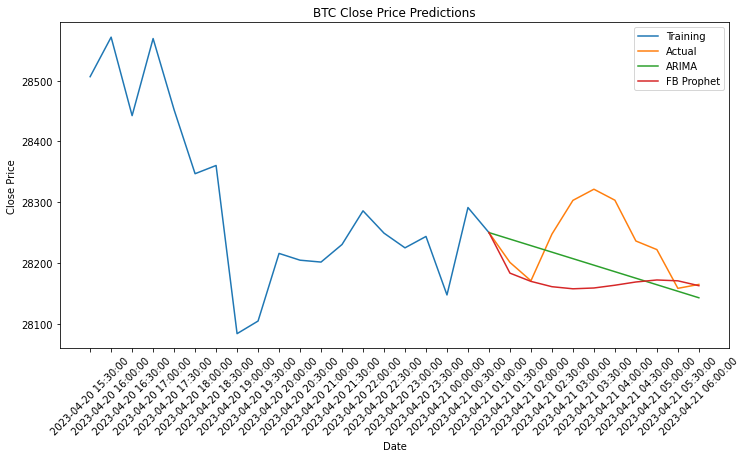

In [16]:
training = train_df30m["close"].values[-20:] 
train_time = train_df30m["datetime"].values[-20:]  

actual = test_df30m["close"].values 
actual_time = test_df30m["datetime"].values 

forecast_df["datetime"] = forecast_df.index 
arima = forecast_df["Prediction"].values 
arima_time = forecast_df["datetime"].values 
arima_time_dt = [] 
for i in range(len(arima_time)): 
    cur_dt = pd.to_datetime(arima_time[i]).strftime("%Y-%m-%d %H:%M:%S") 
    arima_time_dt.append(cur_dt) 

prophet = fb_prophet_df["yhat"].values 
prophet_time = fb_prophet_df["ds"].values 
prophet_time_dt = [] 
for i in range(len(arima_time)): 
    cur_dt = pd.to_datetime(prophet_time[i]).strftime("%Y-%m-%d %H:%M:%S") 
    prophet_time_dt.append(cur_dt) 


plt.figure(figsize=(12, 6)) 
plt.plot(train_time, training, label="Training") 
plt.plot(np.concatenate([train_time[-1:], actual_time]), np.concatenate([training[-1:], actual]), label="Actual") 
plt.plot(np.concatenate([train_time[-1:], arima_time_dt]), np.concatenate([training[-1:], arima]), label="ARIMA") 
plt.plot(np.concatenate([train_time[-1:], prophet_time_dt]), np.concatenate([training[-1:], prophet]), label="FB Prophet") 
plt.title("BTC Close Price Predictions") 
plt.xlabel("Date") 
plt.xticks(rotation=45)
plt.ylabel("Close Price") 
plt.legend()
plt.show()  

# GRU Seq2Seq 학습 + 추론 

In [88]:
!nvidia-smi

Mon Apr 24 08:24:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   51C    P8    37W / 300W |   1437MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [185]:
import pandas as pd 
import numpy as np 
from torch import nn 
import torch
from torch.utils.data import Dataset, DataLoader 
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

In [186]:
df30m = convert_json_to_pd("BTC_USDT-30m-3.json")
df30m.shape

(99234, 6)

In [187]:
train_set = df30m.iloc[:-58] 
test_set = df30m.iloc[-58:]

In [190]:
train_size = int(train_set.shape[0] * 0.8) 
train_df = train_set.iloc[:train_size] 
val_df = train_set.iloc[train_size:] 

train_df.shape, val_df.shape

((79340, 6), (19836, 6))

In [191]:
train_df.drop(columns={"datetime"}, inplace=True) 
val_df.drop(columns={"datetime"}, inplace=True) 

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [192]:
scaler = StandardScaler() 

train_close = train_df["close"].values.reshape((-1,1))  
val_close = val_df["close"].values.reshape((-1,1)) 

scaler.fit(train_close) 

train_close = scaler.transform(train_close) 
val_close = scaler.transform(val_close) 

In [194]:
# 입력으로 30분봉 48개 (24시간 분량), 출력으로 30분봉 10개  
X_train, Y_train = [], [] 

seq_len = 48
target_len = 10 

for i in tqdm(range(train_df.shape[0] - seq_len - target_len), position=0, leave=True): 
    x = train_close[i:i+seq_len]
    y = train_close[i+seq_len:i+seq_len+target_len]
    y0 = np.zeros([1]).reshape((1,1)) # 디코더 첫 입력 추가 
    X_train.append(x) 
    Y_train.append(np.concatenate([y0, y])) 
    
    
X_val, Y_val = [], [] 
for i in tqdm(range(val_df.shape[0] - seq_len - target_len), position=0, leave=True): 
    x = val_close[i:i+seq_len]
    y = val_close[i+seq_len:i+seq_len+target_len]
    y0 = np.zeros([1]).reshape((1,1)) # 디코더 첫 입력 추가 
    X_val.append(x) 
    Y_val.append(np.concatenate([y0, y], axis=0))  

    
X_train = torch.tensor(X_train).float()  
Y_train = torch.tensor(Y_train).float()  

X_val = torch.tensor(X_val).float() 
Y_val = torch.tensor(Y_val).float() 


X_train = torch.reshape(X_train, (-1, seq_len, 1)) 
X_val = torch.reshape(X_val, (-1, seq_len, 1)) 
Y_train = torch.reshape(Y_train, (-1, target_len+1, 1))
Y_val = torch.reshape(Y_val, (-1, target_len+1, 1)) 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

  0%|          | 0/79282 [00:00<?, ?it/s]

  0%|          | 0/19778 [00:00<?, ?it/s]

(torch.Size([79282, 48, 1]),
 torch.Size([79282, 11, 1]),
 torch.Size([19778, 48, 1]),
 torch.Size([19778, 11, 1]))

In [199]:
device = torch.device("cuda:0") 
target_n = 1 
learning_rate = 1e-3 
batch_size = 256 
epochs = 50
teacher_forcing = True 
n_layers = 3 
dropout = 0.2 
window_size = seq_len # 인코더 시퀀스 길이 
future_size = target_len # 디코더 시퀀스 길이 
hidden_dim = 128 
save_path = "best_gru.pt" 

In [196]:
class CustomDataset(Dataset): 
    def __init__(self, encoder_input, decoder_input): 
        self.encoder_input = encoder_input 
        self.decoder_input = decoder_input 
    def __len__(self): 
        return len(self.encoder_input) 
    def __getitem__(self, i): 
        return {
            "encoder_input": torch.tensor(self.encoder_input[i], dtype=torch.float32), 
            "decoder_input": torch.tensor(self.decoder_input[i], dtype=torch.float32) 
        }

In [200]:
train_dataset = CustomDataset(X_train, Y_train) 
val_dataset = CustomDataset(X_val, Y_val) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False) 

In [201]:
# 모델 정의 
class Encoder(nn.Module): 
    def __init__(self, input_dim, hidden_dim, n_layers, dropout): 
        super().__init__() 
        self.n_layers = n_layers 
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)         
    def forward(self, inp_seq): 
        inp_seq = inp_seq.permute(1,0,2) 
        outputs, hidden = self.rnn(inp_seq) 
        return outputs, hidden
    
class BahdanauAttention(nn.Module): 
    def __init__(self, dec_output_dim, units): 
        super(BahdanauAttention, self).__init__() 
        self.W1 = nn.Linear(dec_output_dim, units) 
        self.W2 = nn.Linear(dec_output_dim, units) 
        self.V = nn.Linear(dec_output_dim, 1) 
    def forward(self, hidden, enc_output): 
        query_with_time_axis = hidden.unsqueeze(1) 
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output))) 
        attention_weights = torch.softmax(score, axis=1) 
        context_vector = attention_weights * enc_output 
        context_vector = torch.sum(context_vector, dim = 1) 
        return context_vector, attention_weights 
    
class Decoder(nn.Module): 
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__() 
        self.output_dim = output_dim 
        self.decoder_hidden_dim = decoder_hidden_dim 
        self.n_layers = n_layers 
        self.attention = attention 
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim) 
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout) 
        self.fc_out = nn.Linear(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(dropout) 
    def forward(self, enc_output, dec_input, hidden): 
        dec_input = self.layer(dec_input) 
        context_vector, attention_weight = self.attention(hidden, enc_output) 
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1) 
        dec_input = dec_input.unsqueeze(0) 
        output, hidden = self.rnn(dec_input, hidden) 
        prediction = self.fc_out(output.sum(0)) 
        return prediction, hidden
    
class Seq2Seq(nn.Module): 
    def __init__(self, encoder, decoder, attention): 
        super().__init__() 
        self.encoder = encoder
        self.decoder = decoder 
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1) 
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device) 
        enc_output, hidden = self.encoder(encoder_input) 
        dec_input = decoder_input[:,0] 
        for t in range(1, trg_len): 
            output, hidden = self.decoder(enc_output, dec_input, hidden) 
            outputs[:,t-1] = output
            if teacher_forcing == True: 
                dec_input = decoder_input[:,t] 
            else: 
                dec_input = output 
        return outputs 

In [202]:
encoder = Encoder(input_dim = X_train.shape[-1], hidden_dim = hidden_dim, n_layers = n_layers, dropout=dropout) 
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim) 
decoder = Decoder(
    dec_feature_size = target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n, 
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout, 
    attention=attention 
)

model = Seq2Seq(encoder, decoder, attention) 
model = model.to(device)

In [203]:
# 모델 구조 살펴보기 
model

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(1, 128, num_layers=3, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=128, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (V): Linear(in_features=128, out_features=1, bias=True)
    )
    (layer): Linear(in_features=1, out_features=128, bias=True)
    (rnn): GRU(256, 128, num_layers=3, dropout=0.2)
    (fc_out): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [204]:
loss_func = nn.SmoothL1Loss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) 

def train_step(batch_item, epoch, batch, training, teacher_forcing):
    encoder_input = batch_item['encoder_input'].to(device)
    decoder_input = batch_item['decoder_input'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(encoder_input, decoder_input, teacher_forcing)
            loss = loss_func(output, decoder_input[:,1:])
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(encoder_input, decoder_input, False)
            loss = loss_func(output, decoder_input[:,1:])
        return loss 

In [205]:
loss_plot, val_loss_plot = [], []

best_val_loss = 9999999999

for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epochs"):    
    total_loss, total_val_loss = 0, 0
    total_score, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_loss += batch_loss.item() 
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_val_loss += batch_loss.item() 
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

/tmp/ipykernel_273/3071444893.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "encoder_input": torch.tensor(self.encoder_input[i], dtype=torch.float32),
/tmp/ipykernel_273/3071444893.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "decoder_input": torch.tensor(self.decoder_input[i], dtype=torch.float32)


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

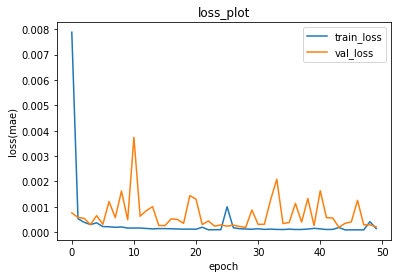

In [207]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.title('loss_plot')
plt.legend()
plt.show()

In [208]:
test_model = torch.load("best_gru.pt")
test_model.to(device) 

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(1, 128, num_layers=3, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=128, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (V): Linear(in_features=128, out_features=1, bias=True)
    )
    (layer): Linear(in_features=1, out_features=128, bias=True)
    (rnn): GRU(256, 128, num_layers=3, dropout=0.2)
    (fc_out): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [209]:
def predict(encoder_input):
    test_model.eval()
    encoder_input = encoder_input.to(device)
    decoder_input = torch.zeros([1, future_size+1, target_n], dtype=torch.float32).to(device)
    with torch.no_grad():
        output = test_model(encoder_input, decoder_input, False)
    return output.cpu()

In [217]:
X_test = test_set["close"].iloc[:-target_len] 
Y_test = test_set["close"].iloc[-target_len:] 

In [218]:
X_test.shape, Y_test.shape

((48,), (10,))

In [219]:
X_test.drop(columns={"datetime"}, inplace=True) 

In [220]:
X_test = scaler.transform(X_test.values.reshape((seq_len,1))) 

X_test.shape

(48, 1)

In [221]:
X_test = torch.tensor(X_test).float() 
X_test = torch.reshape(X_test, (-1, seq_len, 1)) 

X_test.shape

torch.Size([1, 48, 1])

In [222]:
gru_prediction = predict(X_test) 


In [223]:
gru_prediction = torch.reshape(gru_prediction, (10,1)) 

gru_prediction.shape

torch.Size([10, 1])

In [224]:
gru_prediction = scaler.inverse_transform(gru_prediction) 

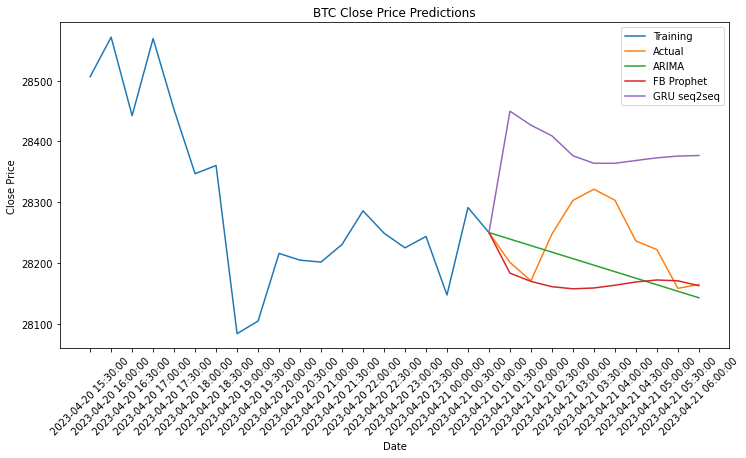

In [228]:
training = train_df30m["close"].values[-20:] 
train_time = train_df30m["datetime"].values[-20:]  

actual = test_df30m["close"].values 
actual_time = test_df30m["datetime"].values 

forecast_df["datetime"] = forecast_df.index 
arima = forecast_df["Prediction"].values 
arima_time = forecast_df["datetime"].values 
arima_time_dt = [] 
for i in range(len(arima_time)): 
    cur_dt = pd.to_datetime(arima_time[i]).strftime("%Y-%m-%d %H:%M:%S") 
    arima_time_dt.append(cur_dt) 

prophet = fb_prophet_df["yhat"].values 
prophet_time = fb_prophet_df["ds"].values 
prophet_time_dt = [] 
for i in range(len(arima_time)): 
    cur_dt = pd.to_datetime(prophet_time[i]).strftime("%Y-%m-%d %H:%M:%S") 
    prophet_time_dt.append(cur_dt) 


plt.figure(figsize=(12, 6)) 
plt.plot(train_time, training, label="Training") 
plt.plot(np.concatenate([train_time[-1:], actual_time]), np.concatenate([training[-1:], actual]), label="Actual") 
plt.plot(np.concatenate([train_time[-1:], arima_time_dt]), np.concatenate([training[-1:], arima]), label="ARIMA") 
plt.plot(np.concatenate([train_time[-1:], prophet_time_dt]), np.concatenate([training[-1:], prophet]), label="FB Prophet") 
plt.plot(np.concatenate([train_time[-1:], prophet_time_dt]), np.concatenate([training[-1:], gru_prediction.reshape((10))]), label="GRU seq2seq") 
plt.title("BTC Close Price Predictions") 
plt.xlabel("Date") 
plt.xticks(rotation=45)
plt.ylabel("Close Price") 
plt.legend()
plt.show()  

# Analysis

작동 방식은 현 시점이 2023-04-21 01:00:00 이라면, 모델들에서 나온 예측값들이 비트코인의 가격 움직임을 예측해서 보여줍니다 (초록, 빨강, 보라색 선들). 그리고 최종 예측 시점인 2023-04-21 06:00:00을 따라잡게 된다면, 실제 가격 움직임 (주황색)을 고려해서 예측값들이 업데이트 됩니다 (즉, 2023-04-21 06:00:00 부터 2023-04-21 11:00:00 까지 새로운 예측 값들이 생성됩니다). 

결과를 보면 선형 모델들이 인공신경망 모델보다 전반적인 추세는 더 잘 잡아내는것으로 보입니다. 하지만 이건 종가 데이터만 고려해서 그렇고, 하이퍼파라미터 튜닝도 수행하지는 않은 POC를 위해 제작한 간단한 인공신경망 모델이라서 그렇습니다. 딥러닝 시계열 분석쪽으로 나온 재밌는 모델들이 많아서 (e.g. ES-RNN, DA-RNN, temporal fusion transformer, informer, etsformer등등), 이러한 모델들을 사용하고 입력 피처들도 multimodal하게 가져가서 예측 성능을 향상시키는 방향으로 저희는 연구를 수행하고 있습니다. 